# TVA

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
from src import utils
from src.outcomes import plurality_outcome, Result
from src.happiness_level import HappinessLevel
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

This is the voting input

In [3]:
voting = utils.read_voting(path_voting)
voting_table = voting.to_pandas()
voting_table

,voter_0,voter_1,voter_2,voter_3,voter_4
preference_0,C,B,C,B,B
preference_1,A,D,D,D,A
preference_2,D,C,A,C,D
preference_3,B,A,B,A,C


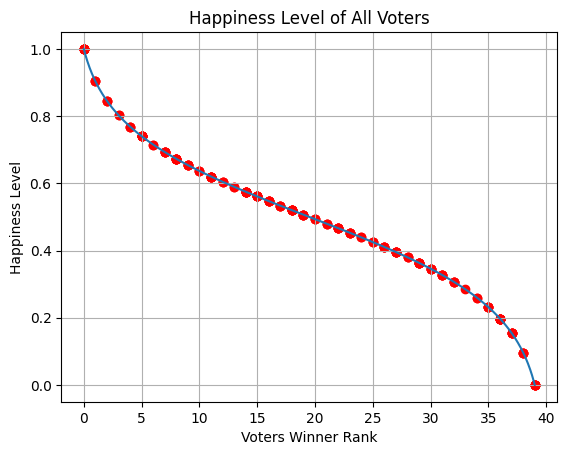

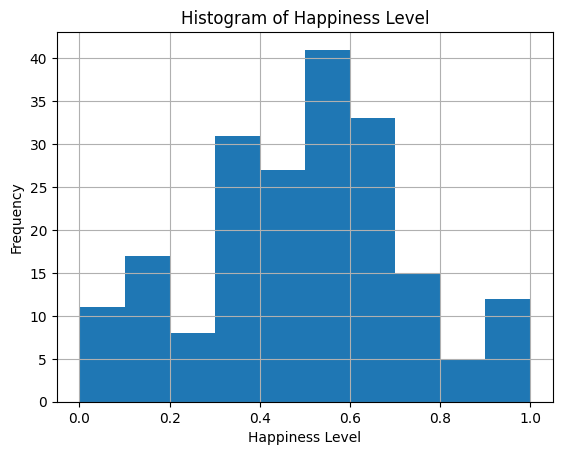

In [4]:
random_voting = utils.random_voting(200, 40)

result = plurality_outcome(random_voting)
happiness_level = HappinessLevel(random_voting, result.winner)
happiness_level.plot()
happiness_level.histogram()